# Out-of-distribution detection with Score-based Generative models

To do: add image of the method


## Introduction

1. Train a time-dependent score model as (Song et.al.)
2. Load the train model

In [1]:
from models import utils as mutils
import datasets
import sde_lib
import sampling 

import os
import torch
import importlib.util
from torch.utils.data import DataLoader

config_dir="./configs/vp/mnist_config.py"
workdir="./results/mnist"
mode="eval"

In [2]:
# Load config file
spec = importlib.util.spec_from_file_location("config_file", config_dir)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)
config=foo.get_config()

In [3]:
# Load trained model and corresponding SDE

# Setup SDEs
if config.training.sde.lower() == "basic_sde":
    sde = sde_lib.BASIC_SDE(sigma=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-3
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")


# Initialize model
score_model = mutils.create_model(config, sde)
score_model = torch.nn.DataParallel(score_model)
score_model = score_model.to(config.device)

# load model
ckpt = torch.load(os.path.join(workdir,'ckpt.pth'), map_location=config.device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [4]:
# Building sampling functions

inverse_scaler = datasets.get_data_inverse_scaler(config)

sampling_shape = (config.training.batch_size, config.data.num_channels,
                  config.data.image_size, config.data.image_size)
sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps)



In [5]:
# get samples given the score_model
samples, n = sampling_fn(score_model)

TypeError: get_score_fn() got an unexpected keyword argument 'continuous'

In [11]:
sampling_shape

(128, 1, 28, 28)

In [13]:
import functools
import numpy as np
import tqdm

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.

    Returns:
      The standard deviation.
    """
    t = t.clone().to(config.device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.

    Returns:
      The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma ** t, device=config.device)
    return (sigma**t).clone().detach().to(config.device)


signal_to_noise_ratio = 0.16  #@param {'type':'number'}

## The number of sampling steps.
num_steps = 500  #@param {'type':'integer'}


def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
      score_model: A PyTorch model that represents the time-dependent score-based model.
      marginal_prob_std: A function that gives the standard deviation
        of the perturbation kernel.
      diffusion_coeff: A function that gives the diffusion coefficient
        of the SDE.
      batch_size: The number of samplers to generate by calling this function once.
      num_steps: The number of sampling steps.
        Equivalent to the number of discretized time steps.
      device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
      eps: The smallest time step for numerical stability.

    Returns:
      Samples.
    """
    scores = []

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g ** 2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size)[:, None, None, None] * torch.randn_like(x)

            scores.append(grad)

        scores = torch.stack(scores, dim=1)

        # The last step does not include any noise
        return x_mean, scores

In [14]:
sigma = 25.0  #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


In [15]:
sample_batch_size = 100 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples, scores = sampler(score_model,
                          marginal_prob_std_fn,
                          diffusion_coeff_fn,
                          sample_batch_size,
                          device=config.device)

  0%|          | 0/500 [00:00<?, ?it/s]

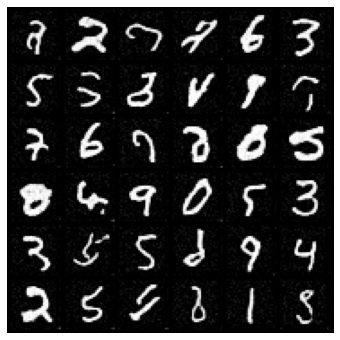

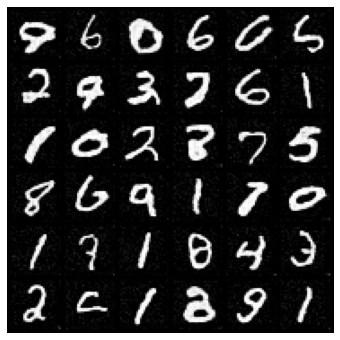

In [16]:
## Sample visualization.
from torchvision.utils import make_grid

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(2):
    sample_grid = make_grid(samples[i*36:(i+1)*36], nrow=int(np.sqrt(36)))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu())
    plt.show()

In [14]:
# Build data iterators
train_ds, eval_ds = datasets.get_dataset(config)

data_loader = DataLoader(train_ds, batch_size=config.training.batch_size, shuffle=True, num_workers=4)
